In [184]:
import numpy as np
import matplotlib.pyplot as plt


## Simulation of self preserving SP's vs FVM gas demand

We design a simple simulation that probes the ability of SP's to solve the problem of gas gentrification by themselves.

### Parameter and pre-defined functions

We assume the value SP's assign to their messages (amount per unit of gas they are willing to pay), is drawn out of some value distribution, $F_{SP}(v)$. We parametrize this as some simple step-like function,
$$F_{SP}(v)=\frac{1}{1+e^{av-b}}-N,$$
$$N=\frac{1}{1+e^{ar_{\rm min}-b}},$$
Where the values of $a,b$ relate to SP OPEX's and demand elasticity, and $r_{\rm min}$ is th minimum base fee. We will use parameters $a=...,$ $b=...$

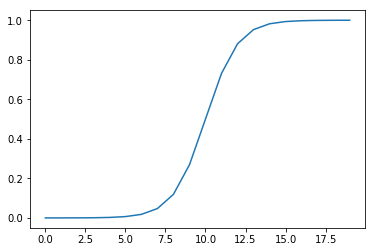

In [230]:
#SP value function


bsp=10 #in units of nanofil, models the threshold where base fee becomes too expensive for SP operations
asp=1   # models the amount of elasticity, how many are still willing to pay if too expensive
bmin=0




def FF(v,a,b,bmin):
    N=1/(1+np.exp(-(a*bmin-b)))
    return (1/(1+np.exp(-(a*v-b))))-N


#define inverse function

def arcFF(f,a,b,bmin):
    N=1/(1+np.exp(-(a*bmin-b)))
    arg=(f+N)  
    ARC=np.log(np.abs(arg/(1-arg)))
    
    
    return (ARC+b)/a
    
    
x=np.arange(bmin,2*bsp)
plt.plot(x,FF(x,asp,bsp,bmin))




We assume the rest of users, which we will collectively refer to as "FVM", assign values to their messages following the distribution $F_{FVM}(v)$. This can in principle be less elastic. We could chose to model it with a similar distribution as $F_{SP}(v)$, but with a much smaller value of $a_{FVM}=.1*a_{SP}$, which would make a much smoother step behavior.

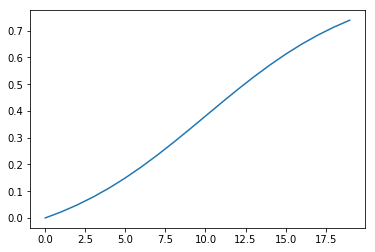

In [442]:
# FVM value function





## For simplicity here we will use the same distribution, but with a higher elasticity, 
#this could be generalized later to any other distribution

bfvm=bsp/5 #in units of nanofil
afvm=asp/5


FFfvm=FF
arcFFfvm=arcFF

x=np.arange(bmin,2*bsp)
plt.plot(x,FFfvm(x,afvm,bfvm,bmin))


We assume for the simulation there will be constant levels of external demand for SP and FVM gas usage. We model this total demand as the quantities $M_{SP}$ and $M_{FVM}$, which are the total amount of gas that SP's and FVM users, respectively, would want to include in the block, regardless of base fees. If there is a given base fee, $r$, only the top paying messages would get on chain. Assuming on average blocks will be sized as the target block size, $B_T$, the relationship between base fee and demand **when both SP and FVM messages are included without discrimination** is given by,
$$ r=F_{SP}^{-1}\left(1-\frac{gB_T}{M_{SP}}\right),$$
$$ r=F_{FVM}^{-1}\left(1-\frac{(1-g)B_T}{M_{FVM}}\right),$$
where $g$ is the proportion of the block that is occupied by SP messages. The above is a system of two equations, that takes demand levels, $M_{SP}$, $M_{FVM}$ as inputs, and produces outputs $r,\,g$.

### Initialize simulation

This simulation will run over a series of time steps (epochs), $t_0,\dots, t_N$. 

We could choose different possible initializations, one simple case we consider is the "Pi Day" scenario, we suppose that before $t_0$, there are only SP messages. After $t_0$ FVM messages start competing with SP's for block space.

In [440]:
## Initial base fee

r0=arcFF(1-BT/MSP,asp,bsp,bmin)
r0

7.697964097817204

At time $t_1$, it will be up to SP's to decide if they maintain the formal block distribution, or if they start allowing FVM to occupy more or less of the block.

## Potential total miner tips

The SP writing the block at a given epoch can opt to include FVM messages or not to include them. Including FVM messages will generally result in a higher revenue for the SP. Here we compute what is the potential maximum revenue an SP can make if they don't discriminate against general FVM messages.

Suppose there is a single gas fee $r$. We define $P_{FVM}$ as the additional profit the SP would make, if they decide to include all possible FVM messages. 

**Simplifying assumption:** We assume that in a stable demand situation, a fraction $y$ of the total gas fee will be miner tips, and the base fee is given by $(1-y)r$.

The potential FVM profit is given by:

If:
$$M_{FVM}\left[1-F_{FVM}(r)\right]+M_{SP}\left[1-F_{SP}(r)\right]<2B_T,$$
then:
$$P_{FVM}=yM_{FVM}\left[1-F_{FVM}(r)\right],$$

Else IF:
$$M_{FVM}\left[1-F_{FVM}(r)\right]+M_{SP}\left[1-F_{SP}(r)\right]>2B_T,$$
then FVM transactions will partially revert to a first price auction mechanism, paying higher tips for inclusion, and,
$$P_{FVM}=\left[2B_T-M_{SP}(1-F_{SP}(r))\right]\cdot (r_{FVM}-(1-y)r),$$
where,
$$r_{FVM}=F^{-1}_{FVM}\left(1-\frac{2B_T-M_{SP}(1-F_{SP}(r)}{M_{FVM}}\right)$$
is the gas fees FVM users would be willing to pay.

In [441]:
## Calculating Potential miner tip

def PP(x,MFVM,MSP,y):
    if MFVM*(1-FFfvm(x,afvm,bfvm,bmin))+MSP*(1-FF(x,asp,bsp,bmin))<2*BT:
        return y*MFVM*(1-FFfvm(x,afvm,bfvm,bmin))
    else:
        arg=1-(2*BT-MSP*(1-FF(x,asp,bsp,bmin)))/MFVM
        rfvm=arcFFfvm(arg,afvm,bfvm,bmin)
        return (2*BT-MSP*(1-FF(x,asp,bsp,bmin)))*(rfvm-(1-y)*x)

### Simulating SP preferences

If SP's were all fully self-preserving, they would limit the amount of gas used by non-SP messages, under-filling the block, such that base fees are lowered for SP's.

We model instead SP behavior as lying on a spectrum of self-preservation. In this simple model, every SP is "self preserving to some extent". SP's are willing to discriminate and include only SP messages, unless there is enough potential profit to be made by including FVM messages. An SP $i$ has a given "temptation threshold", $q_i$, define such that:

If: 
$$q_i< \frac{1}{P_{FVM}},$$
Then the SP will only include SP messages that are able to pay the gas fees.

Else If:
$$q_i> \frac{1}{P_{FVM}},$$
Then the SP will include all messages that are able to pay the gas fees, or all the messages with the highest miner tips, if there are more viable messages than the maximum block size, $2B_T$.



For a given SP, their temptation threshold will be drawn from some distribution,
$$q_i\sim Q(q_i)$$

With the shape of this distribuiton we parametrize how self-preserving SP's are in our simulation.


### Evolution of base fee and block distribution

Here we define the steps of our simulation:

1) Initialize the base fee and block distribution at $t_0$.

2) For j=1,...,N:

1. Draw a temptation threshold for SP, $q_{t_j}$.
2. Evaluate potential FVM profit, $P_{FVM}(t_j)$
3. If $q_{t_j}<1/P_{FVM}(t_j)$, include only SP messages able to pay transaction fee.
4. Else If $q_{t_j}>1/P_{FVM}(t_j)$, include  MIN(All messages able to pay the transaction fee, Maximum block size).
5. Use the block size $B_{t_j}$ to plug into EIP-1559 and obtain gas fee for next epoch, $r_{t_{j+1}}$.


In the end we will have a trajectory of transaction fees over time, From which we can tell if SP's were able to self-preserve (lowering the transaction fees) or not. 



In [479]:
#array of base fees

N=200 #number of epochs

r=np.zeros(N) #array of base fees


####model SP behavior, here we'll use a half normal distribution, but could use something else

from scipy.stats import halfnorm
a=.5
#this parameter controls how self preserving SPs are. 
#Small "a" means SP's are more self-preserving/require higher thresholds to be tempted
q = halfnorm.rvs(0,a, size=N)



y=.01 #percentage of gas fees that is miner tip



#Set relative levels of demand (SP vs FVM)

BT=1
MSP=1.1*BT #in units of target block size
MFVM=1.8*BT

#vector of block sizes
B=np.ones(N)
B[0]=BT



r[0]=arcFF(1-BT/MSP,asp,bsp,bmin)

temp=np.zeros(N)
tempinv=np.zeros(N)

for j in range(1,N):
    if 1/(PP(r[j-1],MFVM,MSP,y))>q[j]:  #self preserving case
        B[j]=MSP*(1-FF(r[j-1],asp,bsp,bmin))
    else:
        B[j]=np.min([MFVM*(1-FF(r[j-1],afvm,bfvm,bmin))+MSP*(1-FF(r[j-1],asp,bsp,bmin)),2*BT])
    
    r[j]= r[j-1]*(1+(1/8)*(B[j]-BT)/(BT))
    temp[j]=1/(PP(r[j-1],MFVM,MSP,y))
    tempinv[j]=PP(r[j-1],MFVM,MSP,y)
    

## Evolution of base fee

We can evaluate whether SP's succeded in self presevation or not, by inspecting the trajectory of the base fee.

If most SP's were highly self preserving (The distribution $Q(q_i)$ is very narrow concentrating only around a small vicinity of $q_i=0$, and then quickly decaying), then base fee should remain at initial value, unaffected by the new influx of FVM messages.

If the distribution is made wider, such that more and more SP's are willing to include general FVM messages for potential miner tips, then fluctuations in base fee start to appear, pushing the base fee up. In the limit of a very wide distribution, the base fee quickly climbs to the equilibrium base fee given by the solution of 
$$ r=F_{SP}^{-1}\left(1-\frac{gB_T}{M_{SP}}\right),$$
$$ r=F_{FVM}^{-1}\left(1-\frac{(1-g)B_T}{M_{FVM}}\right),$$


The exact behavior of the base fee will depend on the relative levels of SP vs FVM demand, $M_{SP},M_{FVM}$, and the shape of the SP behavior distribution (here parametrized simply with a half-normal distribution with standard deviation $a$.

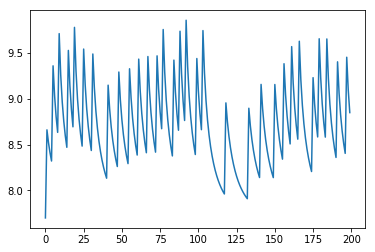

In [480]:
##plotting base fee over time

plt.plot(r)